In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure

In [4]:
df = pd.read_csv('../data/clean/acs_estimate.csv')
df

,borough,total_housing_units,occupied_housing_units,vacant_housing_units,1_room_units,2_room_units,3_room_units,4_room_units,5_room_units,6_room_units,...,unit_4_bedrooms,unit_5+_bedrooms,owner_occupied_units,renter_occupied_units,occupants_per_room_<=1,occupants_per_room_1-1.5,occupants_per_room_>=1.5,owned_median_value,rent_median_value,year
0,STATEN ISLAND,176696,163816,12880,3145,1881,20330,25117,33485,39302,...,23347,7280,114045,49771,157232,5186,1398,452300,1141,2010
1,BRONX,512024,471912,40112,24251,14502,155923,152272,96979,38867,...,18088,9718,88493,383419,413758,37160,20994,388900,974,2010
2,QUEENS,834965,772332,62633,32996,30863,168537,188746,176340,113793,...,58618,28220,338609,433723,703798,44723,23811,464800,1242,2010
3,MANHATTAN,846962,726090,120872,101223,111830,259565,215744,85654,38519,...,22131,7119,161647,564443,683146,23307,19637,825900,1305,2010
4,BROOKLYN,1000000,905317,94683,50285,44652,242503,280610,180657,95177,...,55736,34036,273500,631817,805170,66843,33304,566700,1079,2010
5,STATEN ISLAND,176821,161785,15036,4028,3108,20170,24237,32543,37122,...,21831,7523,111548,50237,155510,4212,2063,441000,1112,2011
6,QUEENS,832195,764825,67370,31672,33297,168681,204414,165069,114301,...,54912,26414,328495,436330,693611,45371,25843,440700,1276,2011
7,MANHATTAN,846177,728520,117657,96989,109009,260129,202038,105320,38227,...,21619,7310,159713,568807,686897,24277,17346,856700,1403,2011
8,BROOKLYN,1001296,901062,100234,55632,51705,252147,283398,168516,90974,...,54436,30693,258193,642869,806487,58681,35894,563200,1113,2011
9,BRONX,512320,467138,45182,28694,14613,147580,153517,100372,37635,...,17238,9074,88816,378322,410513,37190,19435,372100,1012,2011


In [39]:
# HELPER FUNCTIONS 
# Get color palette based on delta value
def get_delta_colors(delta_list):
    return ["green" if i > 0.0 else "red" for i in delta_list]

# Set annotations for values on bar
def set_bar_annotations(ax):
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'),\
        (p.get_x() + p.get_width() / 2,\
        p.get_height()), ha='center', va='center',\
        xytext=(0, 8),\
        textcoords='offset points')
        
# Gets yearly sorty data for any borough based on column `value`
def extract_yearly_sorted_data(df, boro, value):
    return df[df["borough"] == boro][[value, "year", "borough" ]].reset_index(drop=True)

# Compute yearly delta for any boro based on column `value`
def compute_delta(df, boro, value):
    data = extract_yearly_sorted_data(df, boro, value)
    data["delta"] = data[value].diff().replace(np.nan, 0).astype("int")
    return data.drop(columns=[value])

In [40]:
# Create delta df for all boros, must include NYC
def compute_nyc_delta(df):
    boros = df["borough"].unique()
    boros_delta = pd.DataFrame()
    for boro in boros:
        boros_delta = pd.concat([boros_delta, compute_delta(df, boro, "renter_occupied_units")])
    return boros_delta

In [41]:
boros_delta = compute_nyc_delta(df)

In [42]:
# Map chart for FacetGrid
def map_delta(data, color):
    chart = sns.barplot(x=data["year"], y=data["delta"], palette=get_delta_colors(data["delta"].to_list()))
    set_bar_annotations(chart.axes)
    chart.figure.set_size_inches((10,20))

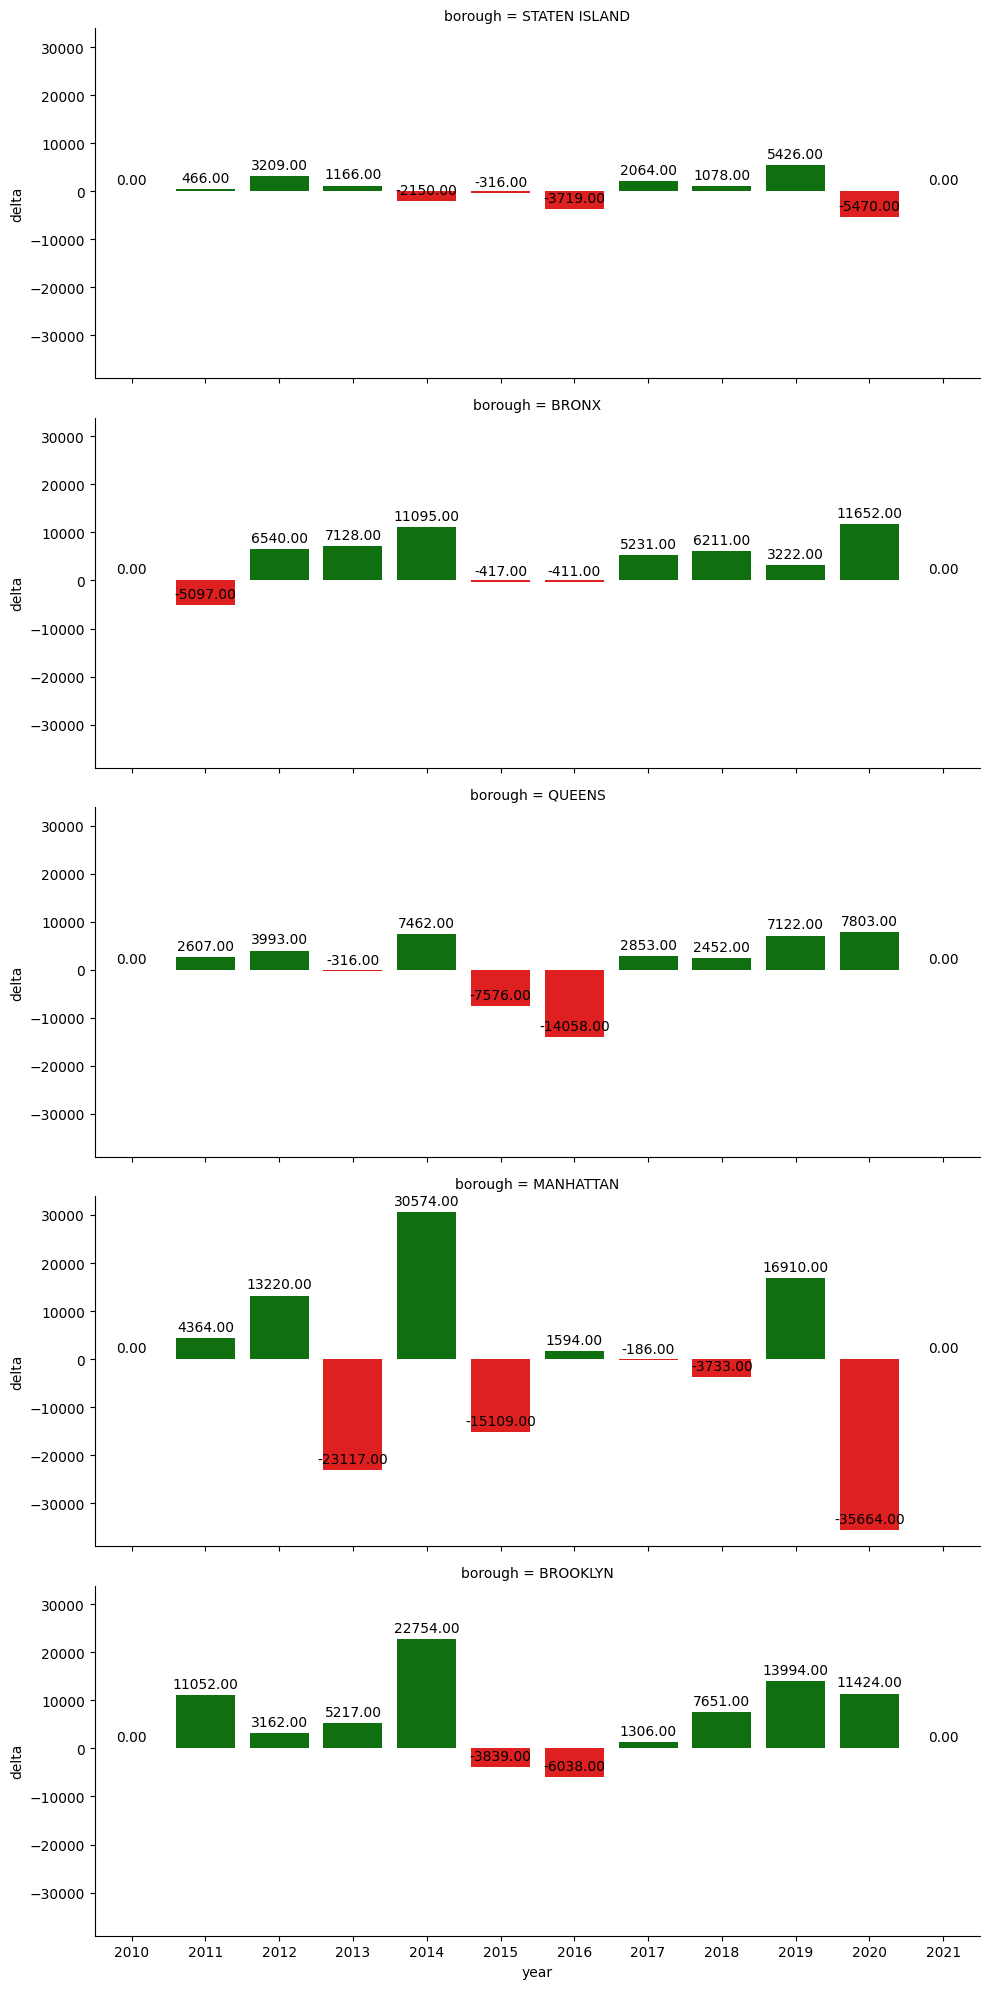

In [43]:
g = sns.FacetGrid(boros_delta, row="borough")
g.map_dataframe(map_delta)

In [75]:
# Get yearly NYC median data for column `value`
def get_nyc_data(df, value):
    nyc_data = df.groupby(["year"])[value].mean().to_frame().reset_index()
    nyc_data["borough"] = "NYC"
    return nyc_data

In [83]:
# Create comparison chart for all boros and NYC based on `value` column
def boro_comparison_line(df, value):
    data = df[["borough", "year", value]]
    nyc_data = get_nyc_data(df, value)
    data = pd.concat([data, nyc_data])
    chart = sns.lineplot(x="year", y=value, hue="borough", data=data)
    chart.axes.set_title(value.replace("_", " ").upper())
    # Move legend outside of graph
    sns.move_legend(chart.axes, "upper left", bbox_to_anchor=(1, 1))

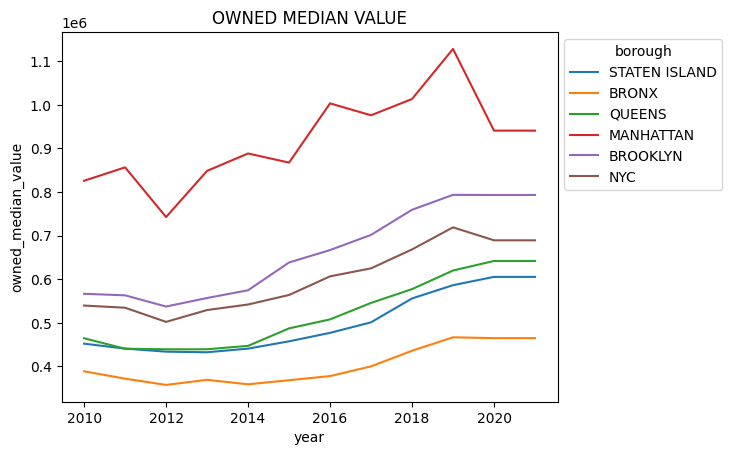

In [84]:
"""
Get boro comparison for specific column
Compares to rest of nyc (averaged on year to year basis)
"""
boro_comparison_line(df, "owned_median_value")

In [85]:
# Create `boro` yearly comparison for columns in `values`
def boro_comparison_bar(df, boro, values):
    comparison = ["year", "borough"] + values
    all_data = df[comparison]
    
    melted_data = pd.melt(all_data, id_vars=['borough', "year" ], value_vars=values)
    boro_data = melted_data[melted_data["borough"] == boro]
    
    chart = sns.barplot(data=boro_data, y="year", x="value", hue="variable", palette="dark", orient="h")
    a = values[0].replace("_", " ").upper()
    b = values[1].replace("_", " ").upper()
    title = "{}: {} vs {}".format(boro, a, b)
    chart.axes.set_title(title)
    # Move legend outside of graph
    sns.move_legend(chart.axes, "upper left", bbox_to_anchor=(1, 1))

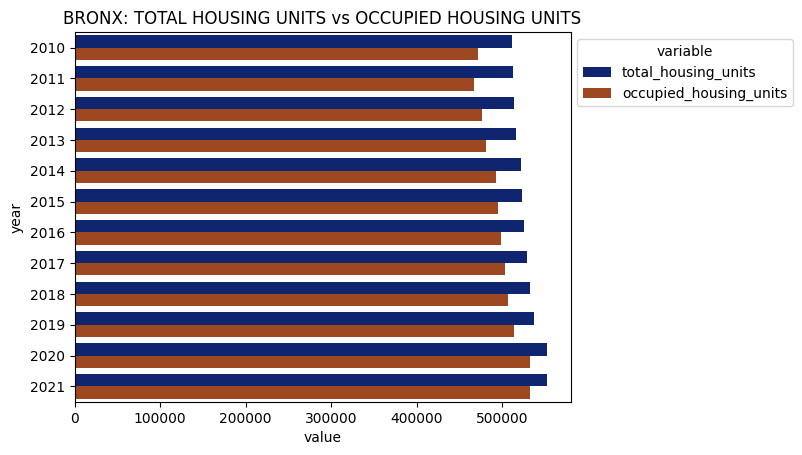

In [96]:
"""
Comparing columns based on boro and values (list of column names)
Only works for 1 boro and specific year (e.g 2010)

"""
boro_comparison_bar(df, "BRONX", ["total_housing_units", "occupied_housing_units"])